# Machine Learning Models Hyperparameter Tuning
This notebook performs hyperparameter tuning for XGBoost and LightGBM models using Optuna optimization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set

Mounted at /content/drive
/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set


In [2]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 27.2 MB/s eta 0:00:00


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
# import warnings
# warnings.filterwarnings('ignore')

# Add tuning directory to path
sys.path.insert(0, '/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set/tuning')

from utils_tuning import (
    load_splits,
    plot_optimization_history,
    train_final_model_and_evaluate,
)
from tune_xgb import tune_xgb, get_base_xgb_params
from tune_lgb import tune_lgb, get_base_lgb_params

In [4]:
# Configuration
config = {
    'output_dir': 'tuning/results',
    'splits_dir': 'training/splits',
    'n_trials': 40,
    'timeout': 3600,  # 1 hour
    'seed': 42,
    'enable_gpu': True,
    'models_to_tune': ['lgb']  # Change this to tune specific models
}

# Create output directory
os.makedirs(config['output_dir'], exist_ok=True)
np.random.seed(config['seed'])

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  output_dir: tuning/results
  splits_dir: training/splits
  n_trials: 40
  timeout: 3600
  seed: 42
  enable_gpu: True
  models_to_tune: ['lgb']


## Load Data Splits
Load the pre-prepared data splits used for training and validation.

In [5]:
print("Loading data splits...")
train_set, val_set, test_set, X_cols, y_cols = load_splits(config['splits_dir'])

print(f"Data loaded successfully:")
print(f"  Train set: {train_set.shape}")
print(f"  Validation set: {val_set.shape}")
print(f"  Test set: {test_set.shape}")
print(f"  Features: {len(X_cols)}")
print(f"  Target: {y_cols}")
print(f"  Unique patients in train: {train_set['Patient_ID'].nunique()}")
print(f"  Unique patients in val: {val_set['Patient_ID'].nunique()}")
print(f"  Unique patients in test: {test_set['Patient_ID'].nunique()}")

Loading data splits...
Data loaded successfully:
  Train set: (14058224, 12)
  Validation set: (1861178, 12)
  Test set: (3945594, 12)
  Features: 8
  Target: ['lead30']
  Unique patients in train: 483
  Unique patients in val: 68
  Unique patients in test: 138


## Hyperparameter Tuning
Perform Optuna-based hyperparameter optimization for each selected model.

In [6]:
def create_args_object(model_name, config):
    """Create an arguments object similar to argparse for compatibility"""
    class Args:
        def __init__(self):
            self.model = model_name
            self.output_dir = config['output_dir']
            self.n_trials = config['n_trials']
            self.timeout = config['timeout']
            self.seed = config['seed']
            self.enable_gpu = config['enable_gpu']
            self.splits_dir = config['splits_dir']

    return Args()

# Store results for comparison
tuning_results = {}

for model_name in config['models_to_tune']:
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} HYPERPARAMETER TUNING")
    print(f"{'='*60}")
    print(f"Method: Optuna Bayesian Optimization")
    print(f"Trials: {config['n_trials']}")
    print(f"Timeout: {config['timeout']}s")
    print(f"GPU enabled: {config['enable_gpu']}")
    print(f"Evaluation metric: Patient-based MAE")
    print(f"{'='*60}")

    # Create args object for compatibility
    args = create_args_object(model_name, config)

    # Run tuning based on model type
    if model_name == 'xgb':
        study, baseline_mae = tune_xgb(train_set, val_set, X_cols, y_cols, args)
        base_params = get_base_xgb_params(config['seed'], config['enable_gpu'])
        model_class = xgb.XGBRegressor
    elif model_name == 'lgb':
        study, baseline_mae = tune_lgb(train_set, val_set, X_cols, y_cols, args)
        base_params = get_base_lgb_params(config['seed'], config['enable_gpu'])
        model_class = lgb.LGBMRegressor

    # Store results
    tuning_results[model_name] = {
        'study': study,
        'baseline_mae': baseline_mae,
        'best_mae': study.best_value,
        'best_params': study.best_params,
        'base_params': base_params,
        'model_class': model_class
    }

    # Print summary
    improvement = baseline_mae - study.best_value
    improvement_pct = (improvement / baseline_mae * 100)

    print(f"\n{'-'*40}")
    print(f"TUNING SUMMARY - {model_name.upper()}")
    print(f"{'-'*40}")
    print(f"Baseline MAE: {baseline_mae:.4f}")
    print(f"Best MAE: {study.best_value:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement_pct:.2f}%)")
    print(f"Best parameters: {study.best_params}")


LGB HYPERPARAMETER TUNING
Method: Optuna Bayesian Optimization
Trials: 40
Timeout: 3600s
GPU enabled: True
Evaluation metric: Patient-based MAE
LightGBM Hyperparameter Tuning
Evaluating baseline LightGBM model...


[I 2025-08-27 18:38:45,935] A new study created in memory with name: lgb_glucose_prediction


LightGBM baseline patient-based MAE: 14.2872
Starting Optuna hyperparameter optimization for LGB...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-08-27 18:39:07,105] Trial 0 finished with value: 14.501864767753599 and parameters: {'num_leaves': 118, 'max_depth': 12, 'min_child_samples': 75, 'min_child_weight': 0.24810409748678125, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'subsample_freq': 1, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'learning_rate': 0.11114989443094977, 'n_estimators': 55, 'min_split_gain': 0.9699098521619943, 'min_data_in_leaf': 43}. Best is trial 0 with value: 14.501864767753599.
[I 2025-08-27 18:39:47,423] Trial 1 finished with value: 16.258829955195075 and parameters: {'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 22, 'min_child_weight': 0.016480446427978974, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'subsample_freq': 3, 'reg_alpha': 0.0032112643094417484, 'reg_lambda': 1.8007140198129195e-07, 'learning_rate': 0.027010527749605478, 'n_estimators': 141, 'min_split_gain': 0.45606998421703593, 'min_data_in_

## Optimization Visualization
Generate plots showing the optimization history for each model.


Generating optimization plots for LGB...
Generating optimization plots for LGB...
Optimization plots saved to: tuning/results/lgb_optimization_analysis.png
Parameter importance saved to: tuning/results/lgb_parameter_importance.csv


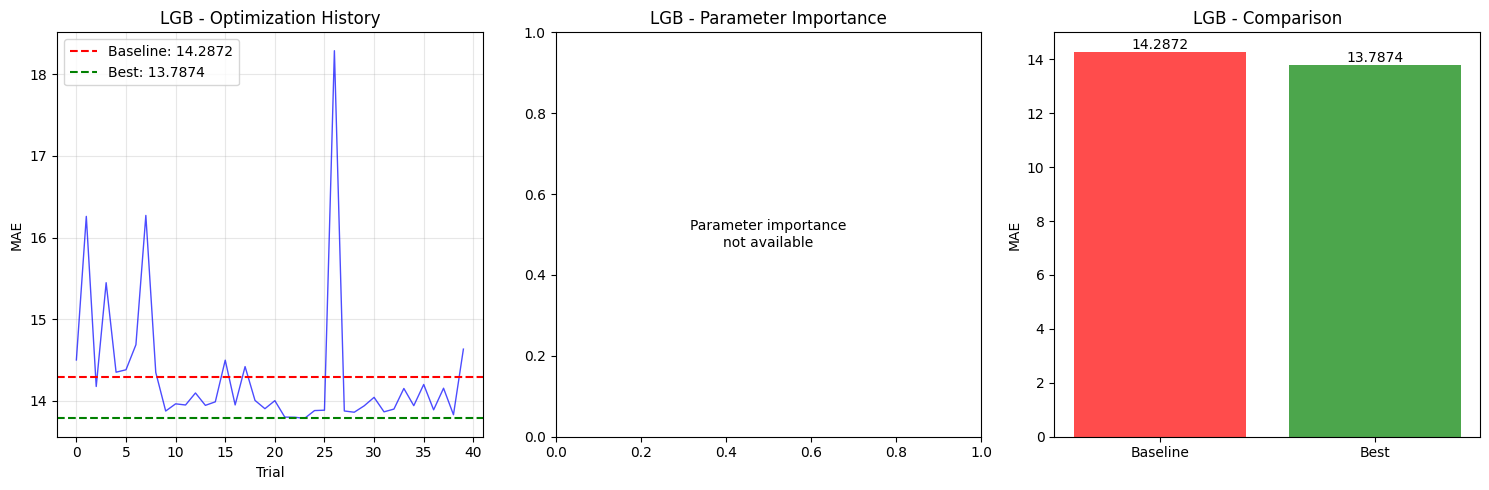

In [7]:
# Generate optimization plots for each model
for model_name, results in tuning_results.items():
    print(f"\nGenerating optimization plots for {model_name.upper()}...")
    plot_optimization_history(results['study'], model_name, config['output_dir'])

    # Display the plot in notebook
    plt.figure(figsize=(15, 5))

    # Plot 1: Optimization History
    plt.subplot(1, 3, 1)
    trials = results['study'].trials
    values = [trial.value for trial in trials if trial.value is not None]
    plt.plot(values, 'b-', alpha=0.7, linewidth=1)
    plt.axhline(y=results['baseline_mae'], color='r', linestyle='--',
                label=f'Baseline: {results["baseline_mae"]:.4f}')
    plt.axhline(y=results['best_mae'], color='g', linestyle='--',
                label=f'Best: {results["best_mae"]:.4f}')
    plt.xlabel('Trial')
    plt.ylabel('MAE')
    plt.title(f'{model_name.upper()} - Optimization History')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Parameter importance
    plt.subplot(1, 3, 2)
    try:
        importances = results['study'].get_trials_dataframe()[
            [col for col in results['study'].get_trials_dataframe().columns
             if col.startswith('params_')]
        ].corrwith(results['study'].get_trials_dataframe()['value']).abs().sort_values(ascending=True)
        importances.plot(kind='barh')
        plt.title(f'{model_name.upper()} - Parameter Correlations')
        plt.xlabel('Absolute Correlation with MAE')
    except:
        plt.text(0.5, 0.5, 'Parameter importance\nnot available',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'{model_name.upper()} - Parameter Importance')

    # Plot 3: Best vs Baseline comparison
    plt.subplot(1, 3, 3)
    models = ['Baseline', 'Best']
    maes = [results['baseline_mae'], results['best_mae']]
    colors = ['red', 'green']
    bars = plt.bar(models, maes, color=colors, alpha=0.7)
    plt.ylabel('MAE')
    plt.title(f'{model_name.upper()} - Comparison')

    # Add value labels on bars
    for bar, mae in zip(bars, maes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{mae:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Final Model Training and Evaluation
Train final models with best parameters and evaluate on test set.

In [8]:
# Train final models and evaluate on test set
final_results = {}

for model_name, results in tuning_results.items():
    print(f"\n{'='*50}")
    print(f"FINAL MODEL TRAINING - {model_name.upper()}")
    print(f"{'='*50}")

    # Combine base parameters with best trial parameters
    best_params = {**results['base_params'], **results['best_params']}

    print(f"Training final model with optimized parameters...")
    print(f"Best parameters: {results['best_params']}")

    # Train final model and evaluate
    final_model, test_results, test_mae = train_final_model_and_evaluate(
        results['model_class'],
        best_params,
        train_set,
        val_set,
        test_set,
        X_cols,
        y_cols,
        config['output_dir'],
        model_name,
    )

    final_results[model_name] = {
        'model': final_model,
        'test_results': test_results,
        'test_mae': test_mae,
        'val_mae': results['best_mae'],
        'baseline_mae': results['baseline_mae']
    }

    improvement = results['baseline_mae'] - results['best_mae']
    improvement_pct = (improvement / results['baseline_mae'] * 100)

    print(f"\nResults for {model_name.upper()}:")
    print(f"  Validation MAE (best trial): {results['best_mae']:.4f}")
    print(f"  Test MAE (final model): {test_mae:.4f}")
    print(f"  Improvement over baseline: {improvement:.4f} ({improvement_pct:.2f}%)")
    print(f"  Model saved to: {config['output_dir']}/{model_name}_best_model.pickle")
    print(f"  Results saved to: {config['output_dir']}/{model_name}_test_results.csv")


FINAL MODEL TRAINING - LGB
Training final model with optimized parameters...
Best parameters: {'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 46, 'min_child_weight': 0.004314290308759151, 'subsample': 0.9009026404822346, 'colsample_bytree': 0.8465815606374963, 'subsample_freq': 6, 'reg_alpha': 1.2649825849245461e-07, 'reg_lambda': 9.315635922604563e-05, 'learning_rate': 0.23157585403052275, 'n_estimators': 270, 'min_split_gain': 0.0034216270099568097, 'min_data_in_leaf': 22}

FINAL MODEL TRAINING AND EVALUATION - LGB
Combined train+val set size: 15919402
Test set size: 3945594

Training final LGB model with best parameters...
Best parameters: {'objective': 'regression', 'metric': 'mae', 'random_state': 42, 'verbosity': -1, 'force_row_wise': True, 'device': 'gpu', 'gpu_use_dp': False, 'num_leaves': 96, 'max_depth': 11, 'min_child_samples': 46, 'min_child_weight': 0.004314290308759151, 'subsample': 0.9009026404822346, 'colsample_bytree': 0.8465815606374963, 'subsample_freq': 6,

## Results Summary and Comparison
Compare the performance of all tuned models.

In [9]:
# Create summary table
summary_data = []
for model_name, results in final_results.items():
    baseline_mae = results['baseline_mae']
    val_mae = results['val_mae']
    test_mae = results['test_mae']
    improvement = baseline_mae - val_mae
    improvement_pct = (improvement / baseline_mae * 100)

    summary_data.append({
        'Model': model_name.upper(),
        'Baseline MAE': f"{baseline_mae:.4f}",
        'Best Val MAE': f"{val_mae:.4f}",
        'Test MAE': f"{test_mae:.4f}",
        'Improvement': f"{improvement:.4f}",
        'Improvement (%)': f"{improvement_pct:.2f}%"
    })

summary_df = pd.DataFrame(summary_data)

print(f"\n{'='*80}")
print("FINAL TUNING SUMMARY")
print(f"{'='*80}")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(f"{config['output_dir']}/tuning_summary.csv", index=False)
print(f"\nSummary saved to: {config['output_dir']}/tuning_summary.csv")


FINAL TUNING SUMMARY
Model Baseline MAE Best Val MAE Test MAE Improvement Improvement (%)
  LGB      14.2872      13.7874  13.4708      0.4999           3.50%

Summary saved to: tuning/results/tuning_summary.csv


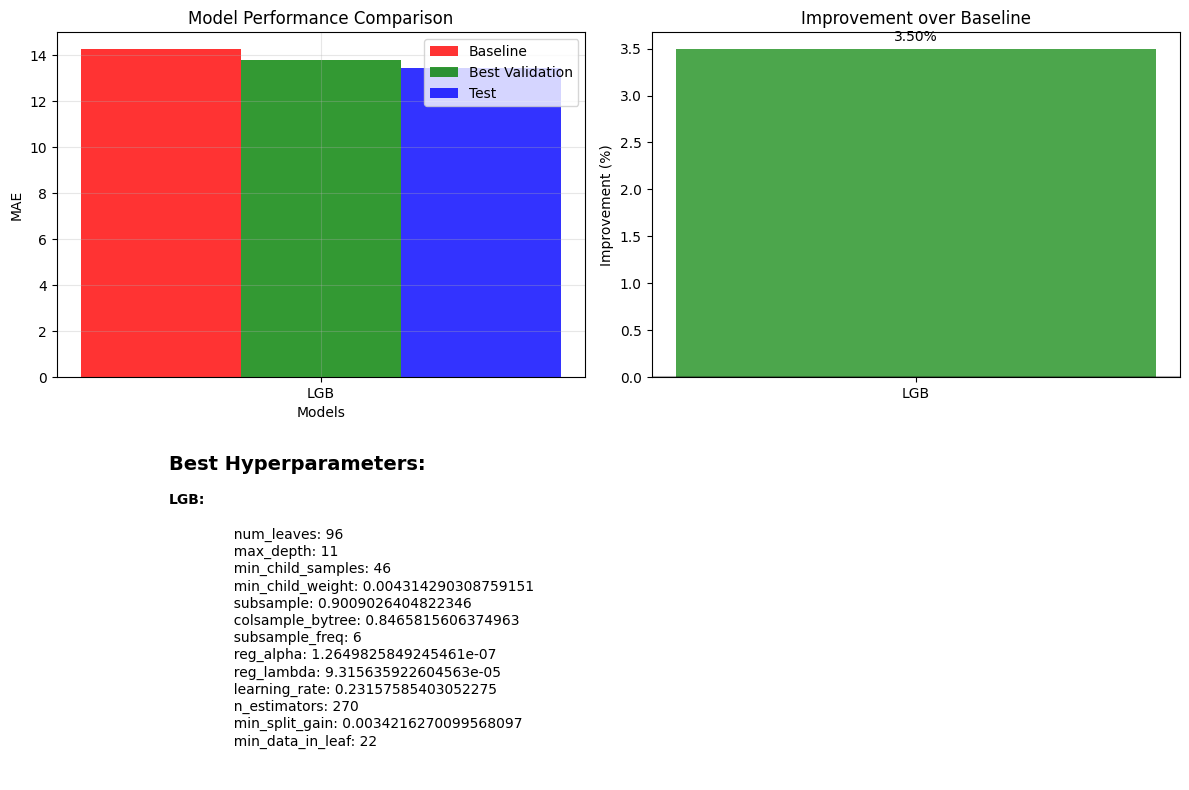


All tuning results saved to: tuning/results

Tuning process completed successfully!


In [10]:
# Visual comparison
plt.figure(figsize=(12, 8))

# Extract data for plotting
models = list(final_results.keys())
baseline_maes = [final_results[m]['baseline_mae'] for m in models]
val_maes = [final_results[m]['val_mae'] for m in models]
test_maes = [final_results[m]['test_mae'] for m in models]

x = np.arange(len(models))
width = 0.25

# Create grouped bar chart
plt.subplot(2, 2, 1)
plt.bar(x - width, baseline_maes, width, label='Baseline', alpha=0.8, color='red')
plt.bar(x, val_maes, width, label='Best Validation', alpha=0.8, color='green')
plt.bar(x + width, test_maes, width, label='Test', alpha=0.8, color='blue')

plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Model Performance Comparison')
plt.xticks(x, [m.upper() for m in models])
plt.legend()
plt.grid(True, alpha=0.3)

# Improvement percentages
plt.subplot(2, 2, 2)
improvements = [(baseline_maes[i] - val_maes[i]) / baseline_maes[i] * 100
                for i in range(len(models))]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
bars = plt.bar([m.upper() for m in models], improvements, color=colors, alpha=0.7)
plt.ylabel('Improvement (%)')
plt.title('Improvement over Baseline')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.05 if imp > 0 else -0.1),
             f'{imp:.2f}%', ha='center', va='bottom' if imp > 0 else 'top')

# Best parameters comparison
plt.subplot(2, 1, 2)
plt.text(0.1, 0.9, 'Best Hyperparameters:', fontsize=14, fontweight='bold',
         transform=plt.gca().transAxes)
y_pos = 0.8
for model_name in models:
    params = tuning_results[model_name]['best_params']
    plt.text(0.1, y_pos, f"{model_name.upper()}:", fontweight='bold',
             transform=plt.gca().transAxes)
    y_pos -= 0.1
    for param, value in params.items():
        plt.text(0.15, y_pos, f"  {param}: {value}",
                transform=plt.gca().transAxes)
        y_pos -= 0.05
    y_pos -= 0.05

plt.axis('off')
plt.tight_layout()
plt.savefig(f"{config['output_dir']}/tuning_summary_plots.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll tuning results saved to: {config['output_dir']}")
print("\nTuning process completed successfully!")

In [11]:
from google.colab import runtime
runtime.unassign()